In [1]:
!wget https://www.dropbox.com/s/l2ul3upj7dkv4ou/synthetic-data.zip
!unzip -qq synthetic-data.zip

--2021-08-10 19:33:19--  https://www.dropbox.com/s/l2ul3upj7dkv4ou/synthetic-data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/l2ul3upj7dkv4ou/synthetic-data.zip [following]
--2021-08-10 19:33:19--  https://www.dropbox.com/s/raw/l2ul3upj7dkv4ou/synthetic-data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce2a4c73c5d0ce2558baf4e2fa7.dl.dropboxusercontent.com/cd/0/inline/BT_9zE-lbX3eIaLTMwCNUX9kqXTu1SIH7TlbrOCiYrxxg44QFBq7rPT2U98ApHRXJTNuHXbDoqKcBIW3fEwmjkU2Oz-dqnwJ9iPvGS4sH3kSq_BMVNgx7851wNMJ1k-UwLSA6IrsXAVbs5llXx51mLDb/file# [following]
--2021-08-10 19:33:20--  https://uce2a4c73c5d0ce2558baf4e2fa7.dl.dropboxusercontent.com/cd/0/inline/BT_9zE-lbX3eIaLTMwCNUX9kqXTu1SIH7TlbrOCiYrxxg44QFBq7rPT2U98ApHRXJTNuHXbD

In [2]:
!pip install torch_snippets torch_summary editdistance

     |████████████████████████████████| 57 kB 3.5 MB/s 
     |████████████████████████████████| 56 kB 5.1 MB/s 
     |████████████████████████████████| 209 kB 14.4 MB/s 
     |████████████████████████████████| 51 kB 9.3 MB/s 


In [3]:
from torch_snippets import *
from torchsummary import summary
import editdistance

2021-08-10 19:33:33.009 | WARNING  | torch_snippets.torch_loader:<module>:233 - Error: No module named 'pytorch_lightning'
Not importing Lightning Report
2021-08-10 19:33:33.609 | WARNING  | torch_snippets:<module>:14 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
fname2label = lambda fname: stem(fname).split('@')[0]
images = Glob('synthetic-data')

2021-08-10 19:33:33.693 | INFO     | torch_snippets.paths:inner:24 - 25132 files found at synthetic-data


In [5]:
vocab = 'QWERTYUIOPASDFGHJKLZXCVBNMqwertyuiopasdfghjklzxcvbnm'
B,T,V = 64, 32, len(vocab) 
H,W = 32, 128 

In [56]:
class OCRDataset(Dataset):
    def __init__(self, items, vocab=vocab, preprocess_shape=(H,W), timesteps=T):
        super().__init__()
        self.items = items
        self.charList = {ix+1:ch for ix,ch in enumerate(vocab)}
        self.charList.update({0: '`'})
        self.invCharList = {v:k for k,v in self.charList.items()}
        self.ts = timesteps
    def __len__(self):
        return len(self.items)
    def sample(self):
        return self[randint(len(self))]
    def __getitem__(self, ix):
        item = self.items[ix]
        image = cv2.imread('/content/synthetic-data', -1)
        label = fname2label(item)
        return image, label
    def collate_fn(self, batch):
        images, labels, label_lengths, label_vectors, input_lengths = [], [], [], [], []
        for image, label in batch:
            images.append(torch.Tensor(self.preprocess(image))[None,None])
            label_lengths.append(len(label))
            labels.append(label)
            label_vectors.append(self.str2vec(label))
            input_lengths.append(self.ts)
        images = torch.cat(images).float().to(device)
        label_lengths = torch.Tensor(label_lengths).long().to(device)
        label_vectors = torch.Tensor(label_vectors).long().to(device)
        input_lengths = torch.Tensor(input_lengths).long().to(device)
        return images, label_vectors, label_lengths, input_lengths, labels
    def str2vec(self, string, pad=True):
        string = ''.join([s for s in string if s in self.invCharList])
        val = list(map(lambda x: self.invCharList[x], string)) 
        if pad:
            while len(val) < self.ts:
                val.append(0)
        return val
    def preprocess(self, img, shape=(32,128)):
        target = np.ones(shape)*255
        try:
            H, W = shape
            h, w = img.shape
            fx = H/h
            fy = W/w
            f = min(fx, fy)
            _h = int(h*f)
            _w = int(w*f)
            _img = cv2.resize(img, (_w,_h))
            target[:_h,:_w] = _img
        except:
            ...
        return (255-target)/255
    def decoder_chars(self, pred):
        decoded = ""
        last = ""
        pred = pred.cpu().detach().numpy()
        for i in range(len(pred)):
            k = np.argmax(pred[i])
            if k > 0 and self.charList[k] != last:
                last = self.charList[k]
                decoded = decoded + last
            elif k > 0 and self.charList[k] == last:
                continue
            else:
                last = ""
        return decoded.replace(" "," ")
    def wer(self, preds, labels):
        c = 0
        for p, l in zip(preds, labels):
            c += p.lower().strip() != l.lower().strip()
        return round(c/len(preds), 4)
    def cer(self, preds, labels):
        c, d = [], []
        for p, l in zip(preds, labels):
            c.append(editdistance.eval(p, l) / len(l))
        return round(np.mean(c), 4)
    def evaluate(self, model, ims, labels, lower=False):
        model.eval()
        preds = model(ims).permute(1,0,2) # B, T, V+1
        preds = [self.decoder_chars(pred) for pred in preds]
        return {'char-error-rate': self.cer(preds, labels),
                'word-error-rate': self.wer(preds, labels),
                'char-accuracy' : 1 - self.cer(preds, labels),
                'word-accuracy' : 1 - self.wer(preds, labels)}


In [57]:
from sklearn.model_selection import train_test_split
trn_items, val_items = train_test_split(Glob('synthetic-data'), test_size=0.2, random_state=22)
trn_ds = OCRDataset(trn_items)
val_ds = OCRDataset(val_items)

trn_dl = DataLoader(trn_ds, batch_size=B, collate_fn=trn_ds.collate_fn, drop_last=True, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=B, collate_fn=val_ds.collate_fn, drop_last=True)

2021-08-10 19:50:36.061 | INFO     | torch_snippets.paths:inner:24 - 25132 files found at synthetic-data


In [58]:
from torch_snippets import Reshape, Permute
class BasicBlock(nn.Module):
    def __init__(self, ni, no, ks=3, st=1, padding=1, pool=2, drop=0.2):
        super().__init__()
        self.ks = ks
        self.block = nn.Sequential(
            nn.Conv2d(ni, no, kernel_size=ks, stride=st, padding=padding),
            nn.BatchNorm2d(no, momentum=0.3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(pool),
            nn.Dropout2d(drop)
        )
    def forward(self, x):
        return self.block(x)

In [59]:
class Ocr(nn.Module):
    def __init__(self, vocab):
        super().__init__()
        self.model = nn.Sequential(
            BasicBlock( 1, 128),
            BasicBlock(128, 128),
            BasicBlock(128, 256, pool=(4,2)),
            Reshape(-1, 256, 32),
            Permute(2, 0, 1) # T, B, D
        )
        self.rnn = nn.Sequential(
            nn.LSTM(256, 256, num_layers=2, dropout=0.2, bidirectional=True),
        )
        self.classification = nn.Sequential(
            nn.Linear(512, vocab+1),
            nn.LogSoftmax(-1),
        )
    def forward(self, x):
        x = self.model(x)
        x, lstm_states = self.rnn(x)
        y = self.classification(x)
        return y

In [60]:
def ctc(log_probs, target, input_lengths, target_lengths, blank=0):
    loss = nn.CTCLoss(blank=blank, zero_infinity=True)
    ctc_loss = loss(log_probs, target, input_lengths, target_lengths)
    return ctc_loss

In [61]:
model = Ocr(len(vocab)).to(device)
!pip install torch_summary
from torchsummary import summary
summary(model, torch.zeros((1,1,32,128)).to(device))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 256]              --
|    └─BasicBlock: 2-1                   [-1, 128, 16, 64]         --
|    |    └─Sequential: 3-1              [-1, 128, 16, 64]         1,536
|    └─BasicBlock: 2-2                   [-1, 128, 8, 32]          --
|    |    └─Sequential: 3-2              [-1, 128, 8, 32]          147,840
|    └─BasicBlock: 2-3                   [-1, 256, 2, 16]          --
|    |    └─Sequential: 3-3              [-1, 256, 2, 16]          295,680
|    └─Reshape: 2-4                      [-1, 256, 32]             --
|    └─Permute: 2-5                      [-1, 1, 256]              --
├─Sequential: 1-2                        [-1, 1, 512]              --
|    └─LSTM: 2-6                         [-1, 1, 512]              2,629,632
├─Sequential: 1-3                        [-1, 1, 53]               --
|    └─Linear: 2-7                       [-1, 1, 53]             

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 256]              --
|    └─BasicBlock: 2-1                   [-1, 128, 16, 64]         --
|    |    └─Sequential: 3-1              [-1, 128, 16, 64]         1,536
|    └─BasicBlock: 2-2                   [-1, 128, 8, 32]          --
|    |    └─Sequential: 3-2              [-1, 128, 8, 32]          147,840
|    └─BasicBlock: 2-3                   [-1, 256, 2, 16]          --
|    |    └─Sequential: 3-3              [-1, 256, 2, 16]          295,680
|    └─Reshape: 2-4                      [-1, 256, 32]             --
|    └─Permute: 2-5                      [-1, 1, 256]              --
├─Sequential: 1-2                        [-1, 1, 512]              --
|    └─LSTM: 2-6                         [-1, 1, 512]              2,629,632
├─Sequential: 1-3                        [-1, 1, 53]               --
|    └─Linear: 2-7                       [-1, 1, 53]             

In [62]:
def train_batch(data, model, optimizer, criterion):
    model.train()
    imgs, targets, label_lens, input_lens, labels = data
    optimizer.zero_grad()
    preds = model(imgs)
    loss = criterion(preds, targets, input_lens, label_lens)
    loss.backward()
    optimizer.step()
    results = trn_ds.evaluate(model, imgs.to(device), labels)
    return loss, results

In [63]:
@torch.no_grad()
def validate_batch(data, model):
    model.eval()
    imgs, targets, label_lens, input_lens, labels = data
    preds = model(imgs)
    loss = criterion(preds, targets, input_lens, label_lens)
    return loss, val_ds.evaluate(model, imgs.to(device), labels)

In [64]:
model = Ocr(len(vocab)).to(device)
criterion = ctc

optimizer = optim.AdamW(model.parameters(), lr=3e-3)

n_epochs = 50
log = Report(n_epochs)

In [65]:
for ep in range( n_epochs):
    # if ep in lr_schedule: optimizer = AdamW(ocr.parameters(), lr=lr_schedule[ep])
    N = len(trn_dl)
    for ix, data in enumerate(trn_dl):
        pos = ep + (ix+1)/N
        loss, results = train_batch(data, model, optimizer, criterion)
        # scheduler.step()
        ca, wa = results['char-accuracy'], results['word-accuracy']
        log.record(pos=pos, trn_loss=loss, trn_char_acc=ca, trn_word_acc=wa, end='\r')
    val_results = []
    N = len(val_dl)
    for ix, data in enumerate(val_dl):
        pos = ep + (ix+1)/N
        loss, results = validate_batch(data, model)
        ca, wa = results['char-accuracy'], results['word-accuracy']
        log.record(pos=pos, val_loss=loss, val_char_acc=ca, val_word_acc=wa, end='\r')

    log.report_avgs(ep+1)
    print()
    for jx in range(5):
        img, label = val_ds.sample()
        _img = torch.Tensor(val_ds.preprocess(img)[None,None]).to(device)
        pred = model(_img)[:,0,:]
        pred = trn_ds.decoder_chars(pred)
        print(f'Pred: `{pred}` :: Truth: `{label}`')
    print()

EPOCH: 1.000	trn_loss: 3.435	trn_char_acc: 0.000	trn_word_acc: 0.000	val_loss: 3.289	val_char_acc: 0.000	val_word_acc: 0.000	(27.78s - 1361.44s remaining)

Pred: `` :: Truth: `along`
Pred: `` :: Truth: `above`
Pred: `` :: Truth: `bad`
Pred: `` :: Truth: `machine`
Pred: `` :: Truth: `pretty`

EPOCH: 2.000	trn_loss: 3.168	trn_char_acc: 0.000	trn_word_acc: 0.000	val_loss: 3.281	val_char_acc: 0.000	val_word_acc: 0.000	(55.41s - 1329.83s remaining)

Pred: `` :: Truth: `health`
Pred: `` :: Truth: `cost`
Pred: `` :: Truth: `list`
Pred: `` :: Truth: `necessary`
Pred: `` :: Truth: `try`

EPOCH: 3.000	trn_loss: 3.145	trn_char_acc: 0.000	trn_word_acc: 0.000	val_loss: 3.322	val_char_acc: 0.000	val_word_acc: 0.000	(82.76s - 1296.61s remaining)

Pred: `` :: Truth: `when`
Pred: `` :: Truth: `despite`
Pred: `` :: Truth: `follow`
Pred: `` :: Truth: `audience`
Pred: `` :: Truth: `five`

EPOCH: 4.000	trn_loss: 3.132	trn_char_acc: 0.047	trn_word_acc: 0.000	val_loss: 3.314	val_char_acc: 0.070	val_word_acc:

100%|██████████| 151/151 [00:00<00:00, 203.39it/s]


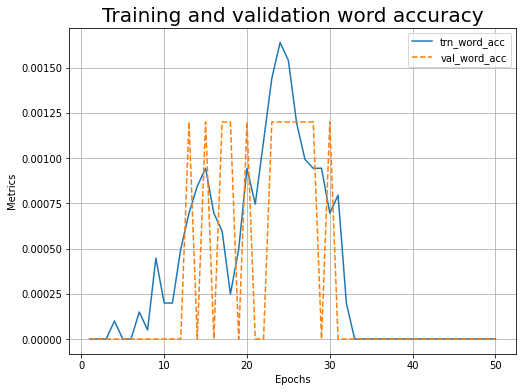

In [66]:
log.plot_epochs(['trn_word_acc','val_word_acc'], title='Training and validation word accuracy')